In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


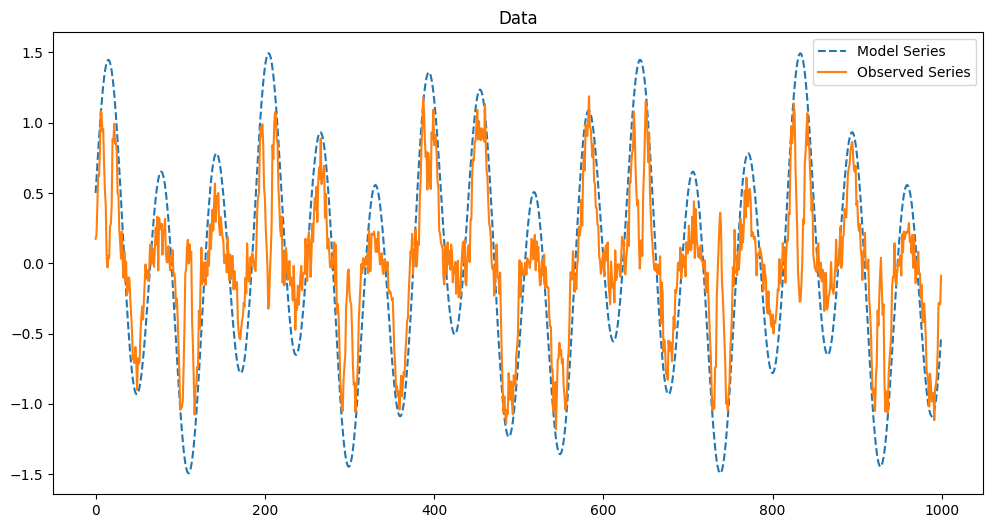

In [2]:

# Параметры
np.random.seed(42)
n = 1000  # длина ряда
t = np.arange(n)

# Модельный ряд
model_series = np.sin(0.1 * t) + 0.5 * np.cos(0.03 * t)

# Наблюдаемый сигнал (нелинейное преобразование + шум)
observed_series = np.sin(model_series**3) + np.random.normal(0, 0.1, n)

plt.figure(figsize=(12, 6))
plt.plot(t, model_series, label='Model Series', linestyle='--')
plt.plot(t, observed_series, label='Observed Series')
plt.title('Data')
plt.legend()
plt.show()


In [3]:
# shapes
model_series.shape, observed_series.shape

((1000,), (1000,))

In [4]:

MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 2

def make_Xy(series, input_size):
    X, y = [], []
    for i in range(len(series) - input_size):
        X.append(series[i:i+input_size])
        y.append(series[i+input_size])
    return np.array(X), np.array(y)

X_model, y_model = make_Xy(model_series, MODEL_SERIES_INPUT_SIZE)
X_observed, y_observed = make_Xy(observed_series, OBSERVED_SERIES_INPUT_SIZE)


In [5]:
# shapes
X_model.shape, y_model.shape, X_observed.shape, y_observed.shape

((996, 4), (996,), (998, 2), (998,))

In [6]:

# make train-test-val split
# model series
X_model_train, X_model_test, y_model_train, y_model_test = train_test_split(X_model, y_model, test_size=0.4, random_state=42, shuffle=False)
X_model_val, X_model_test, y_model_val, y_model_test = train_test_split(X_model_test, y_model_test, test_size=0.7, random_state=42, shuffle=False)

# observed series
X_observed_train, X_observed_test, y_observed_train, y_observed_test = train_test_split(X_observed, y_observed, test_size=0.4, random_state=42, shuffle=False)
X_observed_val, X_observed_test, y_observed_val, y_observed_test = train_test_split(X_observed_test, y_observed_test, test_size=0.7, random_state=42, shuffle=False)


In [7]:
# shapes
X_model_train.shape, X_model_val.shape, X_model_test.shape, y_model_train.shape, y_model_val.shape, y_model_test.shape, X_observed_train.shape, X_observed_val.shape, X_observed_test.shape, y_observed_train.shape, y_observed_val.shape, y_observed_test.shape

((597, 4),
 (119, 4),
 (280, 4),
 (597,),
 (119,),
 (280,),
 (598, 2),
 (120, 2),
 (280, 2),
 (598,),
 (120,),
 (280,))

In [8]:
# cut along 0 axis for X_model_train and X_observed_train (make the min length)
train_len = min(X_model_train.shape[0], X_observed_train.shape[0])
val_len = min(X_model_val.shape[0], X_observed_val.shape[0])
test_len = min(X_model_test.shape[0], X_observed_test.shape[0])

X_model_train, X_observed_train = X_model_train[:train_len], X_observed_train[:train_len]
X_model_val, X_observed_val = X_model_val[:val_len], X_observed_val[:val_len]
X_model_test, X_observed_test = X_model_test[:test_len], X_observed_test[:test_len]

y_model_train, y_observed_train = y_model_train[:train_len], y_observed_train[:train_len]
y_model_val, y_observed_val = y_model_val[:val_len], y_observed_val[:val_len]
y_model_test, y_observed_test = y_model_test[:test_len], y_observed_test[:test_len]



In [9]:

# model+observed series for input
X_train = np.concatenate([X_model_train, X_observed_train], axis=1)
X_val = np.concatenate([X_model_val, X_observed_val], axis=1)
X_test = np.concatenate([X_model_test, X_observed_test], axis=1)


(597, 6) (597, 1)
(119, 6) (119, 1)
(280, 6) (280, 1)


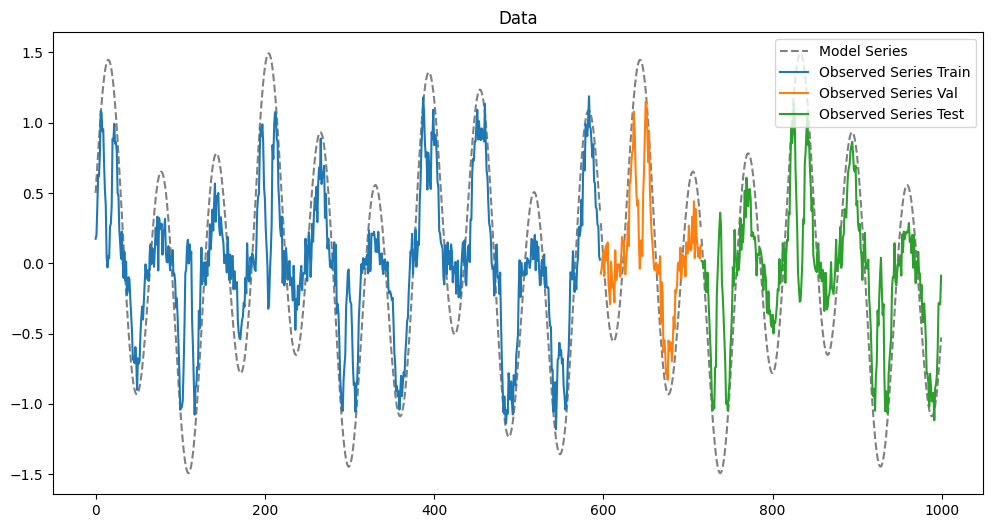

In [10]:

# model+observed series for output
y_train = y_observed_train.reshape(-1, 1)
y_val = y_observed_val.reshape(-1, 1)
y_test = y_observed_test.reshape(-1, 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# plot train-val-test split
plt.figure(figsize=(12, 6))
# model series with -- for train-val-test 
plt.plot(t[:len(X_model_train)], model_series[:len(X_model_train)], linestyle='--', color='grey', label='Model Series')
plt.plot(t[len(X_model_train):len(X_model_train)+len(X_model_val)], model_series[len(X_model_train):len(X_model_train)+len(X_model_val)], linestyle='--', color='grey')
plt.plot(t[len(X_model_train)+len(X_model_val):], model_series[len(X_model_train)+len(X_model_val):], linestyle='--', color='grey')
# observed series for train-val-test
plt.plot(t[:len(X_observed_train)], observed_series[:len(X_observed_train)], label='Observed Series Train')
plt.plot(t[len(X_observed_train):len(X_observed_train)+len(X_observed_val)], observed_series[len(X_observed_train):len(X_observed_train)+len(X_observed_val)], label='Observed Series Val')
plt.plot(t[len(X_observed_train)+len(X_observed_val):], observed_series[len(X_observed_train)+len(X_observed_val):], label='Observed Series Test')
plt.title('Data')
plt.legend()
plt.show()


In [11]:

# define the NARX model
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = self.fc2(out)
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:

def train_model(model, X_train, y_train, X_val, y_val, n_epochs=1000, lr=0.01):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            model.eval()
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
            val_loss = criterion(model(X_val_tensor), y_val_tensor)
            print(f'Epoch {epoch}, Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}')
            
    return model


In [13]:

# train the model
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE+OBSERVED_SERIES_INPUT_SIZE, hidden_size=64, output_size=1)

model = train_model(model, X_train, y_train, X_val, y_val, n_epochs=1000, lr=0.01)


Epoch 0, Loss 0.3850, Val Loss 0.0829
Epoch 100, Loss 0.0224, Val Loss 0.0252
Epoch 200, Loss 0.0218, Val Loss 0.0247
Epoch 300, Loss 0.0208, Val Loss 0.0239
Epoch 400, Loss 0.0192, Val Loss 0.0226
Epoch 500, Loss 0.0176, Val Loss 0.0214
Epoch 600, Loss 0.0167, Val Loss 0.0208
Epoch 700, Loss 0.0161, Val Loss 0.0202
Epoch 800, Loss 0.0155, Val Loss 0.0196
Epoch 900, Loss 0.0149, Val Loss 0.0190


In [15]:

# predict
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_pred = model(X_test_tensor).cpu().detach().numpy()


In [21]:
X_test_tensor.shape, y_pred.shape

(torch.Size([280, 6]), (280, 1))

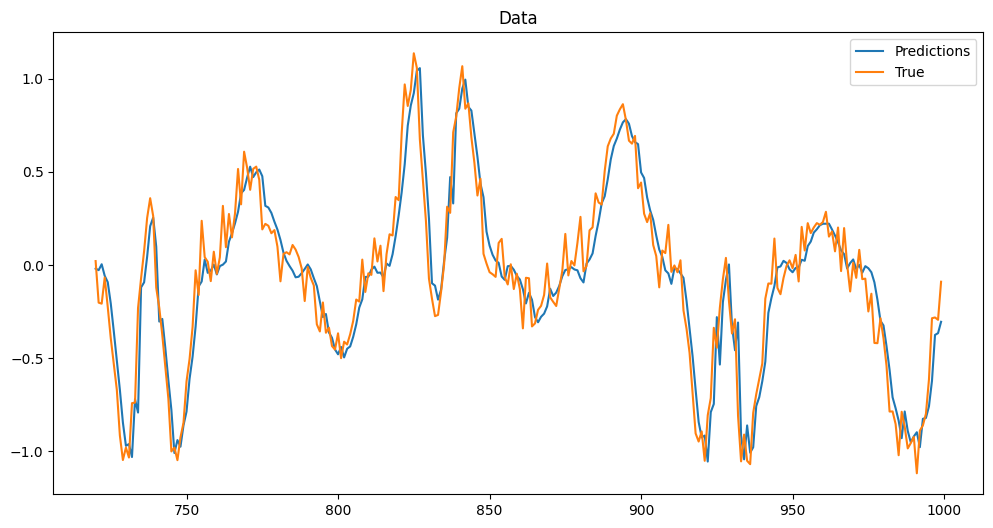

In [25]:

# plot the results 
plt.figure(figsize=(12, 6))
# plt.plot(t[:len(X_observed_train)], observed_series[:len(X_observed_train)], label='Observed Series Train')
# plt.plot(t[len(X_observed_train):len(X_observed_train)+len(X_observed_val)], observed_series[len(X_observed_train):len(X_observed_train)+len(X_observed_val)], label='Observed Series Val')
# plt.plot(t[len(X_observed_train)+len(X_observed_val):], observed_series[len(X_observed_train)+len(X_observed_val):], label='Observed Series Test')
# # plt.plot(t[len(X_observed_train)+len(X_observed_val)+OBSERVED_SERIES_INPUT_SIZE:], y_pred, label='Predictions')
plt.plot(t[-len(y_pred):], y_pred, label='Predictions')
plt.plot(t[-len(y_test):], y_test, label='True')
plt.title('Data')
plt.legend()
plt.show()


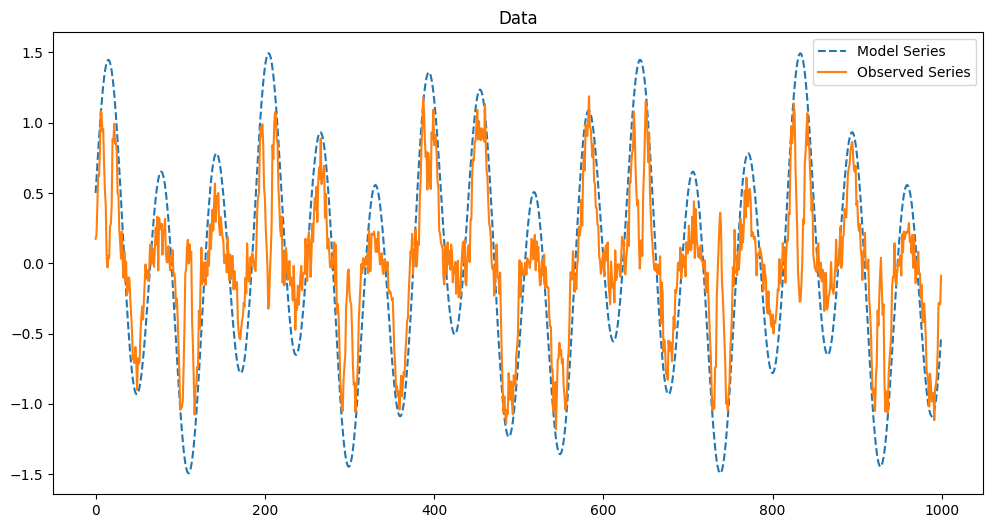

(597, 6) (597, 1)
(119, 6) (119, 1)
(280, 6) (280, 1)


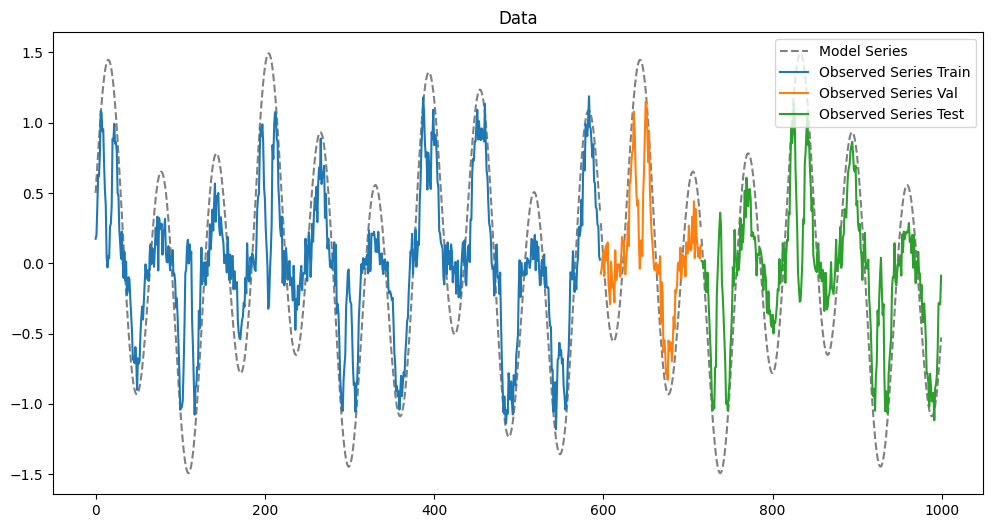

Epoch 0, Loss 0.1974, Val Loss 0.0673
Epoch 100, Loss 0.0222, Val Loss 0.0253
Epoch 200, Loss 0.0210, Val Loss 0.0241
Epoch 300, Loss 0.0186, Val Loss 0.0223
Epoch 400, Loss 0.0170, Val Loss 0.0211
Epoch 500, Loss 0.0159, Val Loss 0.0200
Epoch 600, Loss 0.0146, Val Loss 0.0182
Epoch 700, Loss 0.0136, Val Loss 0.0170
Epoch 800, Loss 0.0127, Val Loss 0.0163
Epoch 900, Loss 0.0126, Val Loss 0.0164


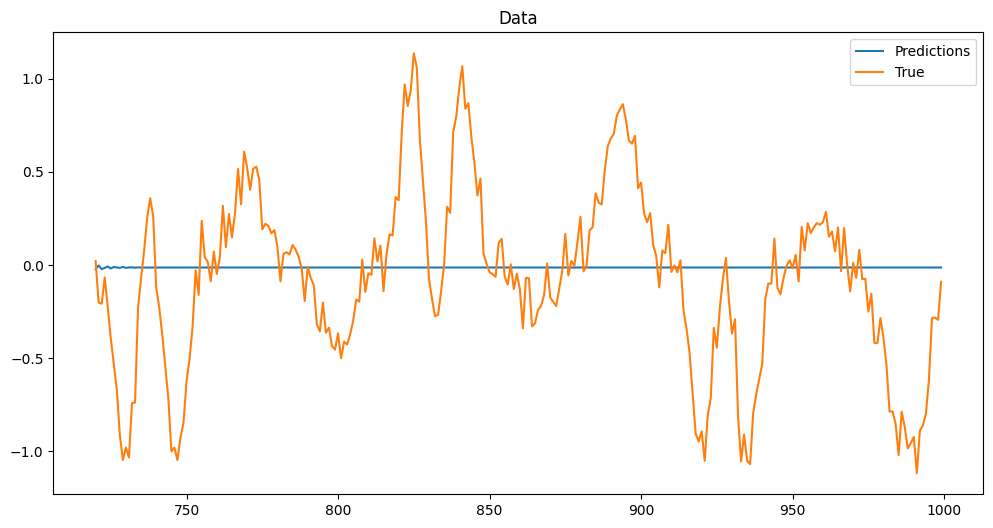

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Параметры
np.random.seed(42)
n = 1000  # длина ряда
t = np.arange(n)

# Модельный ряд
model_series = np.sin(0.1 * t) + 0.5 * np.cos(0.03 * t)

# Наблюдаемый сигнал (нелинейное преобразование + шум)
observed_series = np.sin(model_series**3) + np.random.normal(0, 0.1, n)

plt.figure(figsize=(12, 6))
plt.plot(t, model_series, label='Model Series', linestyle='--')
plt.plot(t, observed_series, label='Observed Series')
plt.title('Data')
plt.legend()
plt.show()

# shapes
model_series.shape, observed_series.shape

MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 2

def make_Xy(series, input_size):
    X, y = [], []
    for i in range(len(series) - input_size):
        X.append(series[i:i+input_size])
        y.append(series[i+input_size])
    return np.array(X), np.array(y)

X_model, y_model = make_Xy(model_series, MODEL_SERIES_INPUT_SIZE)
X_observed, y_observed = make_Xy(observed_series, OBSERVED_SERIES_INPUT_SIZE)

# shapes
X_model.shape, y_model.shape, X_observed.shape, y_observed.shape

# make train-test-val split
# model series
X_model_train, X_model_test, y_model_train, y_model_test = train_test_split(X_model, y_model, test_size=0.4, random_state=42, shuffle=False)
X_model_val, X_model_test, y_model_val, y_model_test = train_test_split(X_model_test, y_model_test, test_size=0.7, random_state=42, shuffle=False)

# observed series
X_observed_train, X_observed_test, y_observed_train, y_observed_test = train_test_split(X_observed, y_observed, test_size=0.4, random_state=42, shuffle=False)
X_observed_val, X_observed_test, y_observed_val, y_observed_test = train_test_split(X_observed_test, y_observed_test, test_size=0.7, random_state=42, shuffle=False)

# shapes
X_model_train.shape, X_model_val.shape, X_model_test.shape, y_model_train.shape, y_model_val.shape, y_model_test.shape, X_observed_train.shape, X_observed_val.shape, X_observed_test.shape, y_observed_train.shape, y_observed_val.shape, y_observed_test.shape

# cut along 0 axis for X_model_train and X_observed_train (make the min length)
train_len = min(X_model_train.shape[0], X_observed_train.shape[0])
val_len = min(X_model_val.shape[0], X_observed_val.shape[0])
test_len = min(X_model_test.shape[0], X_observed_test.shape[0])

X_model_train, X_observed_train = X_model_train[:train_len], X_observed_train[:train_len]
X_model_val, X_observed_val = X_model_val[:val_len], X_observed_val[:val_len]
X_model_test, X_observed_test = X_model_test[:test_len], X_observed_test[:test_len]

y_model_train, y_observed_train = y_model_train[:train_len], y_observed_train[:train_len]
y_model_val, y_observed_val = y_model_val[:val_len], y_observed_val[:val_len]
y_model_test, y_observed_test = y_model_test[:test_len], y_observed_test[:test_len]

# model+observed series for input
X_train = np.concatenate([X_model_train, X_observed_train], axis=1)
X_val = np.concatenate([X_model_val, X_observed_val], axis=1)
X_test = np.concatenate([X_model_test, X_observed_test], axis=1)

# model+observed series for output
y_train = y_observed_train.reshape(-1, 1)
y_val = y_observed_val.reshape(-1, 1)
y_test = y_observed_test.reshape(-1, 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# plot train-val-test split
plt.figure(figsize=(12, 6))
# model series with -- for train-val-test 
plt.plot(t[:len(X_model_train)], model_series[:len(X_model_train)], linestyle='--', color='grey', label='Model Series')
plt.plot(t[len(X_model_train):len(X_model_train)+len(X_model_val)], model_series[len(X_model_train):len(X_model_train)+len(X_model_val)], linestyle='--', color='grey')
plt.plot(t[len(X_model_train)+len(X_model_val):], model_series[len(X_model_train)+len(X_model_val):], linestyle='--', color='grey')
# observed series for train-val-test
plt.plot(t[:len(X_observed_train)], observed_series[:len(X_observed_train)], label='Observed Series Train')
plt.plot(t[len(X_observed_train):len(X_observed_train)+len(X_observed_val)], observed_series[len(X_observed_train):len(X_observed_train)+len(X_observed_val)], label='Observed Series Val')
plt.plot(t[len(X_observed_train)+len(X_observed_val):], observed_series[len(X_observed_train)+len(X_observed_val):], label='Observed Series Test')
plt.title('Data')
plt.legend()
plt.show()

# define the NARX model
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = self.fc2(out)
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, X_train, y_train, X_val, y_val, n_epochs=1000, lr=0.01):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            model.eval()
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
            val_loss = criterion(model(X_val_tensor), y_val_tensor)
            print(f'Epoch {epoch}, Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}')
            
    return model

# train the model
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE+OBSERVED_SERIES_INPUT_SIZE, hidden_size=64, output_size=1)
model = train_model(model, X_train, y_train, X_val, y_val, n_epochs=1000, lr=0.01)

# predict
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_pred = []

# Initialize the input sequence with the last part of the test set
input_seq = X_test_tensor[0].unsqueeze(0)

for _ in range(len(y_test)):
    with torch.no_grad():
        pred = model(input_seq)
        y_pred.append(pred.item())
        new_input = torch.cat((input_seq[:, 1:], pred), dim=1)

        input_seq = new_input

y_pred = np.array(y_pred)

# plot the results 
plt.figure(figsize=(12, 6))
plt.plot(t[-len(y_pred):], y_pred, label='Predictions')
plt.plot(t[-len(y_test):], y_test, label='True')
plt.title('Data')
plt.legend()
plt.show()
